In [1]:
SCHOOL="harvard"
SUBJECT="opinion"
START_YEAR=2010
FINAL_YEAR=2022
TOPIC_EMBEDDING_MODEL = "all-MiniLM-L6-v2" # alt: "all-mpnet-base-v2"
DATA_DIR="data"      # should be 'data'
OUTPUT_DIR="output"  # should be 'output'

In [2]:
import math
import os
import numpy as np
import pandas as pd

import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import spacy
nlp = spacy.load("en_core_web_lg")

2023-01-25 19:30:58.107318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
%pwd

'/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges'

In [4]:
# NOTE: for input data & outputs to work, we need to be in the main project folder
%cd ..

/Users/theodoremui/Library/CloudStorage/OneDrive-Personal/dev/diversity-colleges


In [5]:
import sys
sys.path.append('src')
import ouraws
import ourgraphs
import textutil

In [6]:
# NOTE: before loading, we need to be in the "collegier" folder

S3OBJECT_KEY = f"{DATA_DIR}/{SCHOOL}-{SUBJECT}-SNAPSHOT.parquet"
df = ouraws.getFromS3(S3OBJECT_KEY)

In [7]:
df.shape

(5029, 6)

In [8]:
df.columns

Index(['title', 'url', 'body', 'year', 'month', 'day'], dtype='object')

In [9]:
df["year"].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2003, 1999, 1997, 1996, 1975,
       2004, 2002, 1960])

In [18]:
RESULTS_OUTPUT = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-diversity-results.parquet"
# results_df = pd.read_parquet(RESULTS_OUTPUT)

In [15]:
results = []
for year in range(START_YEAR, FINAL_YEAR+1):
    year_df = df[df.year==year]

    if year_df.shape[0] > 0:
        docs_df, num_diversity_words = textutil.filterText(year_df.body) 
        wv = [nlp(s) for s in docs_df]
        docvecs = np.array([v.vector for v in wv])
        
        pairwise = textutil.getNormalizedPairwiseDispersion(docvecs)
        cov = textutil.getCovDispersion(docvecs)
        
        print("{:<10}{:<10}{:<10}{:<10.3e}{:<10.3e}{:<10.3e}{:<10.3f}".format(
            year, cov[0], num_diversity_words, cov[1], cov[2], cov[3], pairwise
        ))

        result = {'year':       year,
                'mentions':     num_diversity_words,
                'mention-norm': num_diversity_words / cov[0],
                'pairwise':     pairwise,
                'size':         cov[0],
                'trace':        cov[1],
                'norm-1':       cov[2], 
                'norm-2':       cov[3], 
                'norm-inf':     cov[4], 
                }
        results.append(result)

2010      473       139       1.892e+00 2.030e+00 1.757e+00 0.075     
2011      478       201       1.904e+00 2.046e+00 1.780e+00 0.068     
2012      454       196       1.905e+00 2.056e+00 1.784e+00 0.065     
2013      471       118       1.893e+00 1.999e+00 1.749e+00 0.077     
2014      454       139       1.898e+00 2.066e+00 1.754e+00 0.077     
2015      307       225       1.914e+00 2.063e+00 1.765e+00 0.079     
2016      321       227       1.937e+00 2.055e+00 1.796e+00 0.074     
2017      323       248       1.953e+00 2.048e+00 1.815e+00 0.072     
2018      312       187       1.945e+00 2.073e+00 1.815e+00 0.068     
2019      306       259       1.942e+00 2.068e+00 1.827e+00 0.060     
2020      288       172       1.894e+00 2.020e+00 1.777e+00 0.063     
2021      272       142       1.823e+00 1.906e+00 1.701e+00 0.068     
2022      379       196       1.844e+00 1.933e+00 1.721e+00 0.067     


In [17]:
results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')

,mentions,mention-norm,pairwise,size,trace,norm-1,norm-2,norm-inf
year,,,,,,,,
2010,139,0.293869,0.075250,473,1.891645,2.030299,1.756548,2.030299
2011,201,0.420502,0.067569,478,1.904400,2.045506,1.779850,2.045506
2012,196,0.431718,0.064878,454,1.904792,2.056079,1.784374,2.056079
2013,118,0.250531,0.076799,471,1.892607,1.998524,1.748889,1.998524
2014,139,0.306167,0.077046,454,1.898285,2.065888,1.754107,2.065888
2015,225,0.732899,0.078734,307,1.913682,2.063337,1.764648,2.063337
2016,227,0.707165,0.073515,321,1.936728,2.054515,1.795933,2.054515
2017,248,0.767802,0.072065,323,1.953162,2.047704,1.815017,2.047704
2018,187,0.599359,0.067672,312,1.944612,2.072992,1.815258,2.072992


In [27]:
results_df.to_parquet(RESULTS_OUTPUT)

## Diversity Word Mentions vs Diversity of Ideas

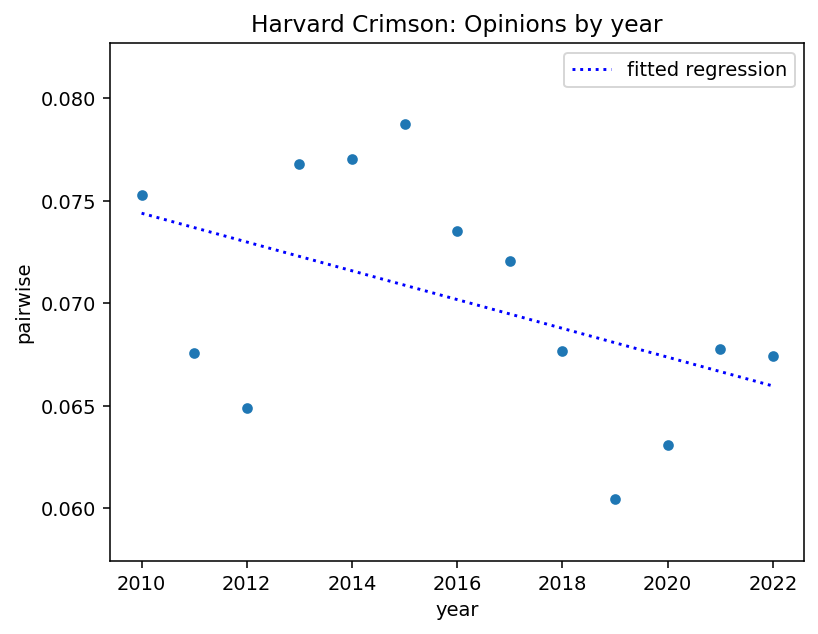

In [28]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

x = results_df['year']
y = results_df['pairwise']

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Create a line plot of the data
results_df.plot(x="year", y="pairwise", kind="scatter")

# Add the linear regression line to the plot
plt.plot(x, intercept + slope*x, 'b:', label='fitted regression')

plt.title("Harvard Crimson: Opinions by year")
plt.legend(loc='upper right')
plt.ylim(min(y)*0.95, max(y)*1.05)
plt.show()

mention-norm slope:0.02702, int:0.37577, r:0.54740, p-value:0.05283, se:0.01246, x:range(0, 13)
pairwise slope:-0.00070, int:0.07438, r:-0.47098, p-value:0.10427, se:0.00040, x:range(0, 13)
trace slope:-0.00253, int:1.91841, r:-0.25919, p-value:0.39249, se:0.00284, x:range(0, 13)
norm-1 slope:-0.00669, int:2.06798, r:-0.49473, p-value:0.08566, se:0.00354, x:range(0, 13)
norm-2 slope:-0.00125, int:1.77993, r:-0.13208, p-value:0.66711, se:0.00284, x:range(0, 13)
norm-inf slope:-0.00669, int:2.06798, r:-0.49473, p-value:0.08566, se:0.00354, x:range(0, 13)


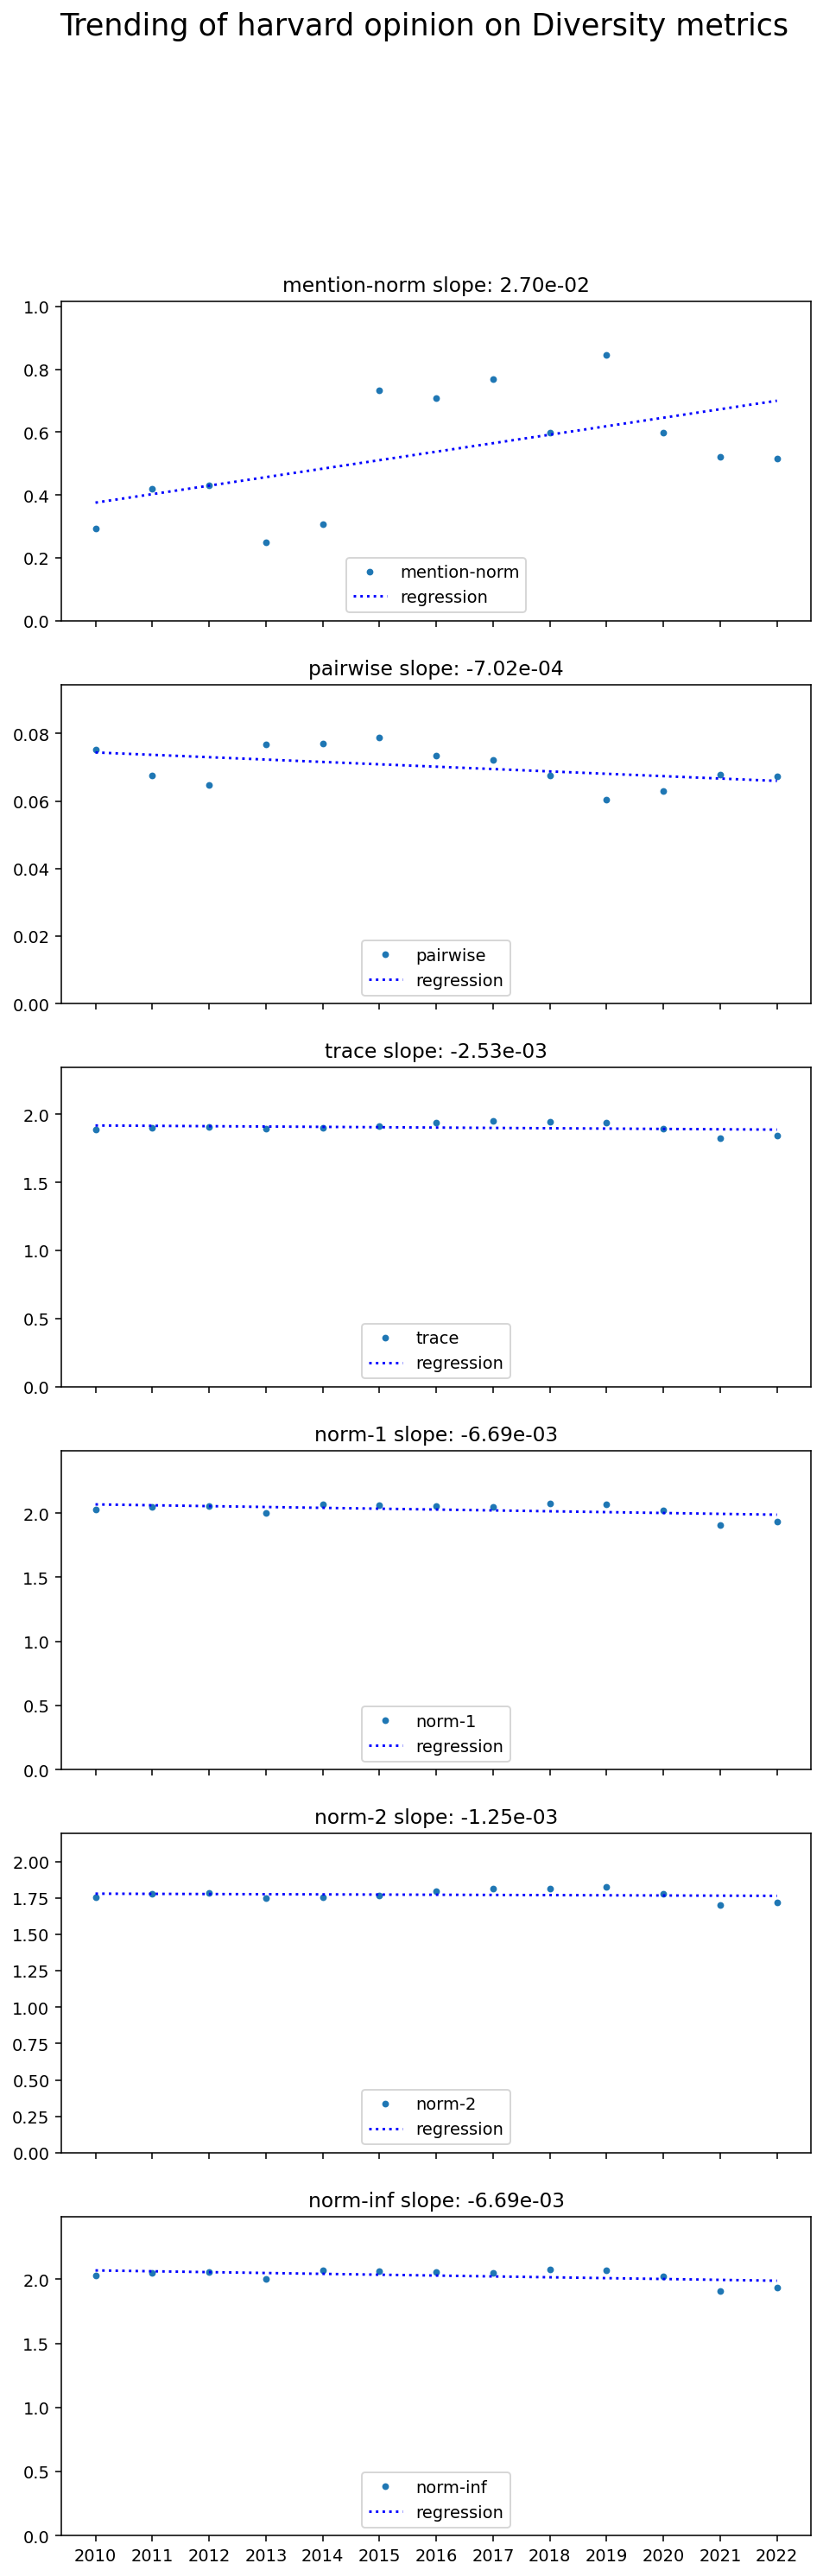

In [29]:
title = "Trending of {} {} on Diversity metrics".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise", "trace", "norm-1", "norm-2", "norm-inf"]
graph = ourgraphs.showTopicsResults(results_df, title, columns)
graph.show()

mention-norm slope:0.02702, int:0.37577, r:0.54740, p:0.05283, se:0.01246, x:range(0, 13)
pairwise slope:-0.00070, int:0.07438, r:-0.47098, p:0.10427, se:0.00040, x:range(0, 13)


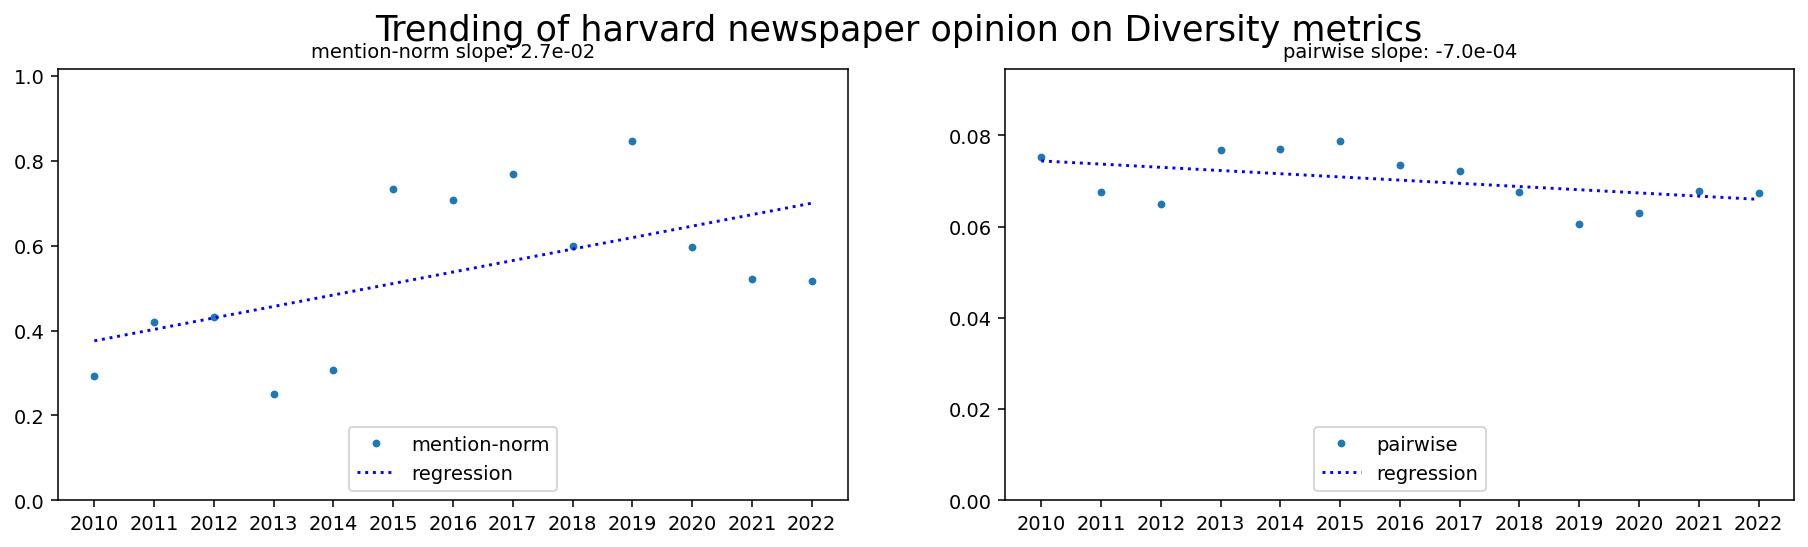

In [32]:
title = "Trending of {} newspaper {} on Diversity metrics\n".format(
    SCHOOL, SUBJECT
)
columns = ["mention-norm", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(results_df, title, columns)
graph.show()

## Topic Modeling

In [34]:
from bertopic import BERTopic

BERTOPIC_FILENAME = f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-BERTopic-model"
# to load a saved one: 
#      topic_model = SentenceTransformer.from_pretrained(BERTOPIC_FILENAME)

# if os.path.exists(BERTOPIC_FILENAME):
#     print("Are you sure that you don't want to load a saved transformer? ")
# else:
topic_model = BERTopic(embedding_model=TOPIC_EMBEDDING_MODEL)

AttributeError: module 'numba' has no attribute 'njit'

In [47]:
all_docs, num_diversity_words = textutil.filterText(df.body)

In [48]:
# This is a very EXPENSIVE operation: do it with care!
# Alternatively, load it with SentenceTransformer (see above)
topics, probs = topic_model.fit_transform(all_docs.to_list())

In [49]:
topic_model.save(BERTOPIC_FILENAME)

In [50]:
topic_info = topic_model.get_topic_info()
topic_info.shape

(103, 3)

In [51]:
topic_info.head(15)

,Topic,Count,Name
0,-1,1984,-1_it_the_berkeley_one
1,0,175,0_black_white_american_asian
2,1,165,1_asuc_student_senate_candidate
3,2,163,2_sex_sexual_porn_partner
4,3,112,3_dailycal_wp_uploads_https
5,4,109,4_israel_palestinian_jewish_israeli
6,5,108,5_hair_body_beauty_look
7,6,98,6_climate_fossil_fuel_environmental
8,7,85,7_religion_muslim_religious_islam
9,8,76,8_police_officer_bpd_city


In [52]:
topic_model.get_topic(0)

[('black', 0.02024514517228433),
 ('white', 0.01779645044590748),
 ('american', 0.013446671068676428),
 ('asian', 0.012433992226313332),
 ('people', 0.010540848516993547),
 ('chinese', 0.00867100417767298),
 ('culture', 0.008363492791283487),
 ('identity', 0.00831492028244058),
 ('family', 0.007720302113622698),
 ('it', 0.007053674774865069)]

In [53]:
doc_info = topic_model.get_document_info(all_docs.to_list())
doc_info.head(15)

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,opening the end semester always come certain l...,18,18_book_writing_write_reading,book - writing - write - reading - read - ve -...,1.000000,False
1,a look economic disparity among asian american...,0,0_black_white_american_asian,black - white - american - asian - people - ch...,0.985940,False
2,spitter quitter nothing used scare looming bre...,2,2_sex_sexual_porn_partner,sex - sexual - porn - partner - orgasm - it - ...,1.000000,False
3,on ignoring matt walsh conservative love sendi...,-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
4,"what woman? last week, unexpected visitor camp...",50,50_feminist_woman_feminism_women,feminist - woman - feminism - women - men - ge...,0.180283,False
5,"hopping pond when people meet today, fact i gr...",14,14_home_back_road_car,home - back - road - car - ve - place - it - h...,0.931937,False
6,support graduate student throughout doctoral p...,-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
7,will real republican please stand up? the repu...,69,69_republican_party_democrat_gop,republican - party - democrat - gop - compromi...,1.000000,False
8,"failing uc berkeley someone told me, “if go uc...",-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False
9,"let happiness burn when i child, mom used coll...",-1,-1_it_the_berkeley_one,it - the - berkeley - one - time - student - w...,0.000000,False


### Visualize Topics

Call `.visualize_topics` to create a 2D representation of your topics. The resulting graph is a plotly interactive graph which can be converted to HTML:

In [54]:
topic_model.visualize_topics()

### Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help to select an appropriate nr_topics when reducing the number of topics that you have created. To visualize this hierarchy, run the following:

In [55]:
topic_model.visualize_hierarchy()

### Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other. To visualize this hierarchy, run the following:

In [56]:
topic_model.visualize_barchart()

In [57]:
topic_model.visualize_term_rank()

## Topics over Time


In [58]:
all_docs, all_docs_years = textutil.filterTextWithYears(df.body, df.year)

In [59]:
topics_over_time = topic_model.topics_over_time(all_docs, all_docs_years)

In [60]:
topic_model.visualize_topics_over_time(topics_over_time)

In [61]:
topics_over_time 

,Topic,Words,Frequency,Timestamp,Name
0,-1,"the, student, it, one, berkeley",126,2011,-1_it_the_berkeley_one
1,0,"race, korean, dispute, caucasian, argument",2,2011,0_black_white_american_asian
2,1,"asuc, student, auxiliary, party, change",6,2011,1_asuc_student_senate_candidate
3,2,"sex, orgasm, you, it, partner",26,2011,2_sex_sexual_porn_partner
4,3,"dailycal, wp, uploads, jpg, https",10,2011,3_dailycal_wp_uploads_https
...,...,...,...,...,...
928,89,"mental, health, heat, student, stress",2,2022,89_mental_health_gpa_student
929,92,"bisexual, label, sexuality, straight, gay",3,2022,92_bisexual_sexuality_label_queer
930,93,"neuron, spinal, cord, neurons, autism",1,2022,93_autism_autistic_autistics_neuron
931,96,"earthquake, building, seismic, city, emergency",1,2022,96_earthquake_seismic_building_preparedn...


In [62]:
topics_over_time = topics_over_time[topics_over_time.Topic != -1]

In [63]:
topics_over_time

,Topic,Words,Frequency,Timestamp,Name
1,0,"race, korean, dispute, caucasian, argument",2,2011,0_black_white_american_asian
2,1,"asuc, student, auxiliary, party, change",6,2011,1_asuc_student_senate_candidate
3,2,"sex, orgasm, you, it, partner",26,2011,2_sex_sexual_porn_partner
4,3,"dailycal, wp, uploads, jpg, https",10,2011,3_dailycal_wp_uploads_https
5,4,"israel, palestinian, israeli, jewish, statehood",3,2011,4_israel_palestinian_jewish_israeli
...,...,...,...,...,...
928,89,"mental, health, heat, student, stress",2,2022,89_mental_health_gpa_student
929,92,"bisexual, label, sexuality, straight, gay",3,2022,92_bisexual_sexuality_label_queer
930,93,"neuron, spinal, cord, neurons, autism",1,2022,93_autism_autistic_autistics_neuron
931,96,"earthquake, building, seismic, city, emergency",1,2022,96_earthquake_seismic_building_preparedn...


In [64]:
len(topic_model.topic_embeddings_[0])

384

### Extract topic embeddings for each year

In [65]:
results = []
for year in range(2011, 2023):
    topics_series = topics_over_time[topics_over_time.Timestamp==year].Topic
    
    topic_embeddings = []
    for topic in topics_series:
        topic_embeddings.append(topic_model.topic_embeddings_[topic])
    pairwise_measure = textutil.getNormalizedPairwiseDispersion(topic_embeddings)
    cov = textutil.getCovDispersion(topic_embeddings)
        
    results.append({
        'year': year,
        'topics_count': topics_series.nunique(),
        'size'        : df[df.year == year].shape[0],
        'topics_norm' : topics_series.nunique() / df[df.year == year].shape[0],
        'pairwise'    : pairwise_measure,
        'trace'       : cov[1],
        'norm-1'      : cov[2],
        'norm-2'      : cov[3],
        'norm-inf'    : cov[4]
    })
    
topics_trend_df = pd.DataFrame.from_records(results)

In [66]:
topics_trend_df.set_index('year')

,topics_count,pairwise,trace,norm-1,norm-2,norm-inf
year,,,,,,
2011,62,0.405426,0.001196,0.000793,0.000713,0.000793
2012,77,0.414340,0.001191,0.000784,0.000698,0.000784
2013,82,0.420013,0.001202,0.000787,0.000697,0.000787
2014,76,0.414980,0.001194,0.000789,0.000698,0.000789
2015,83,0.412356,0.001186,0.000789,0.000697,0.000789
2016,83,0.417408,0.001195,0.000788,0.000695,0.000788
2017,84,0.414436,0.001194,0.000788,0.000698,0.000788
2018,82,0.416560,0.001190,0.000782,0.000694,0.000782
2019,79,0.415513,0.001188,0.000783,0.000694,0.000783


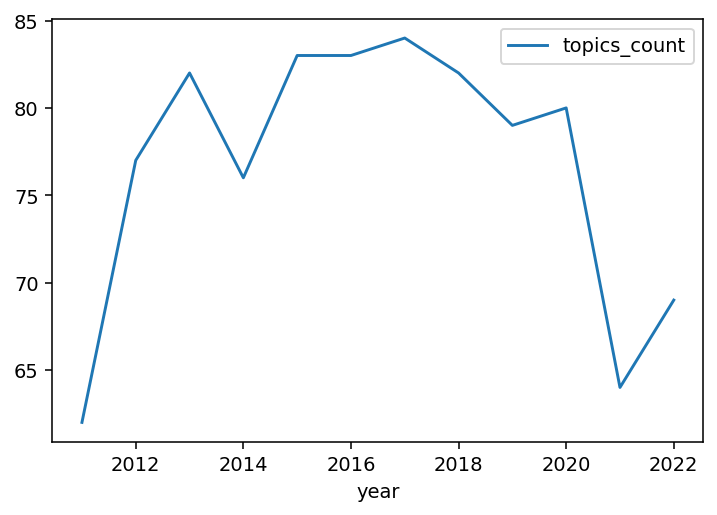

In [67]:
topics_trend_df.plot(x='year', y='topics_count', kind='line')

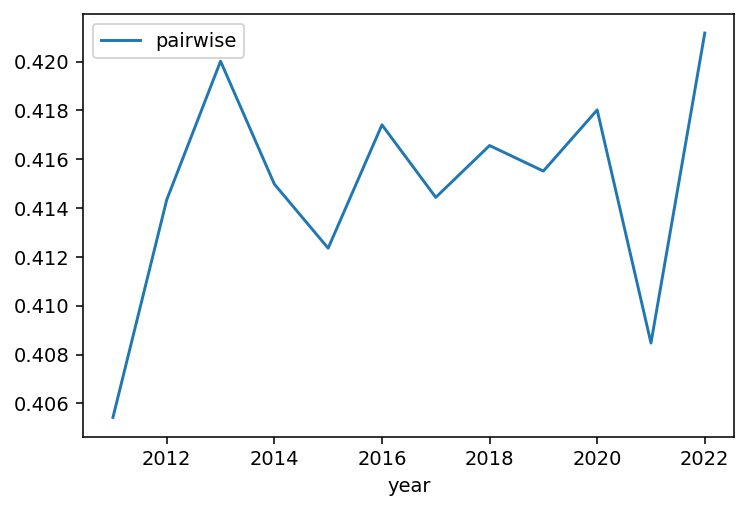

In [68]:
topics_trend_df.plot(x='year', y='pairwise', kind='line')

topics_count slope:-0.14336, int:77.53846, r:-0.06764, p-value:0.83454, se:0.66863, x:range(0, 12)
pairwise slope:0.00041, int:0.41261, r:0.33257, p-value:0.29087, se:0.00037, x:range(0, 12)
trace slope:-0.00000, int:0.00120, r:-0.70798, p-value:0.00999, se:0.00000, x:range(0, 12)
norm-1 slope:-0.00000, int:0.00079, r:-0.56231, p-value:0.05703, se:0.00000, x:range(0, 12)
norm-2 slope:-0.00000, int:0.00070, r:-0.57726, p-value:0.04937, se:0.00000, x:range(0, 12)
norm-inf slope:-0.00000, int:0.00079, r:-0.56231, p-value:0.05703, se:0.00000, x:range(0, 12)


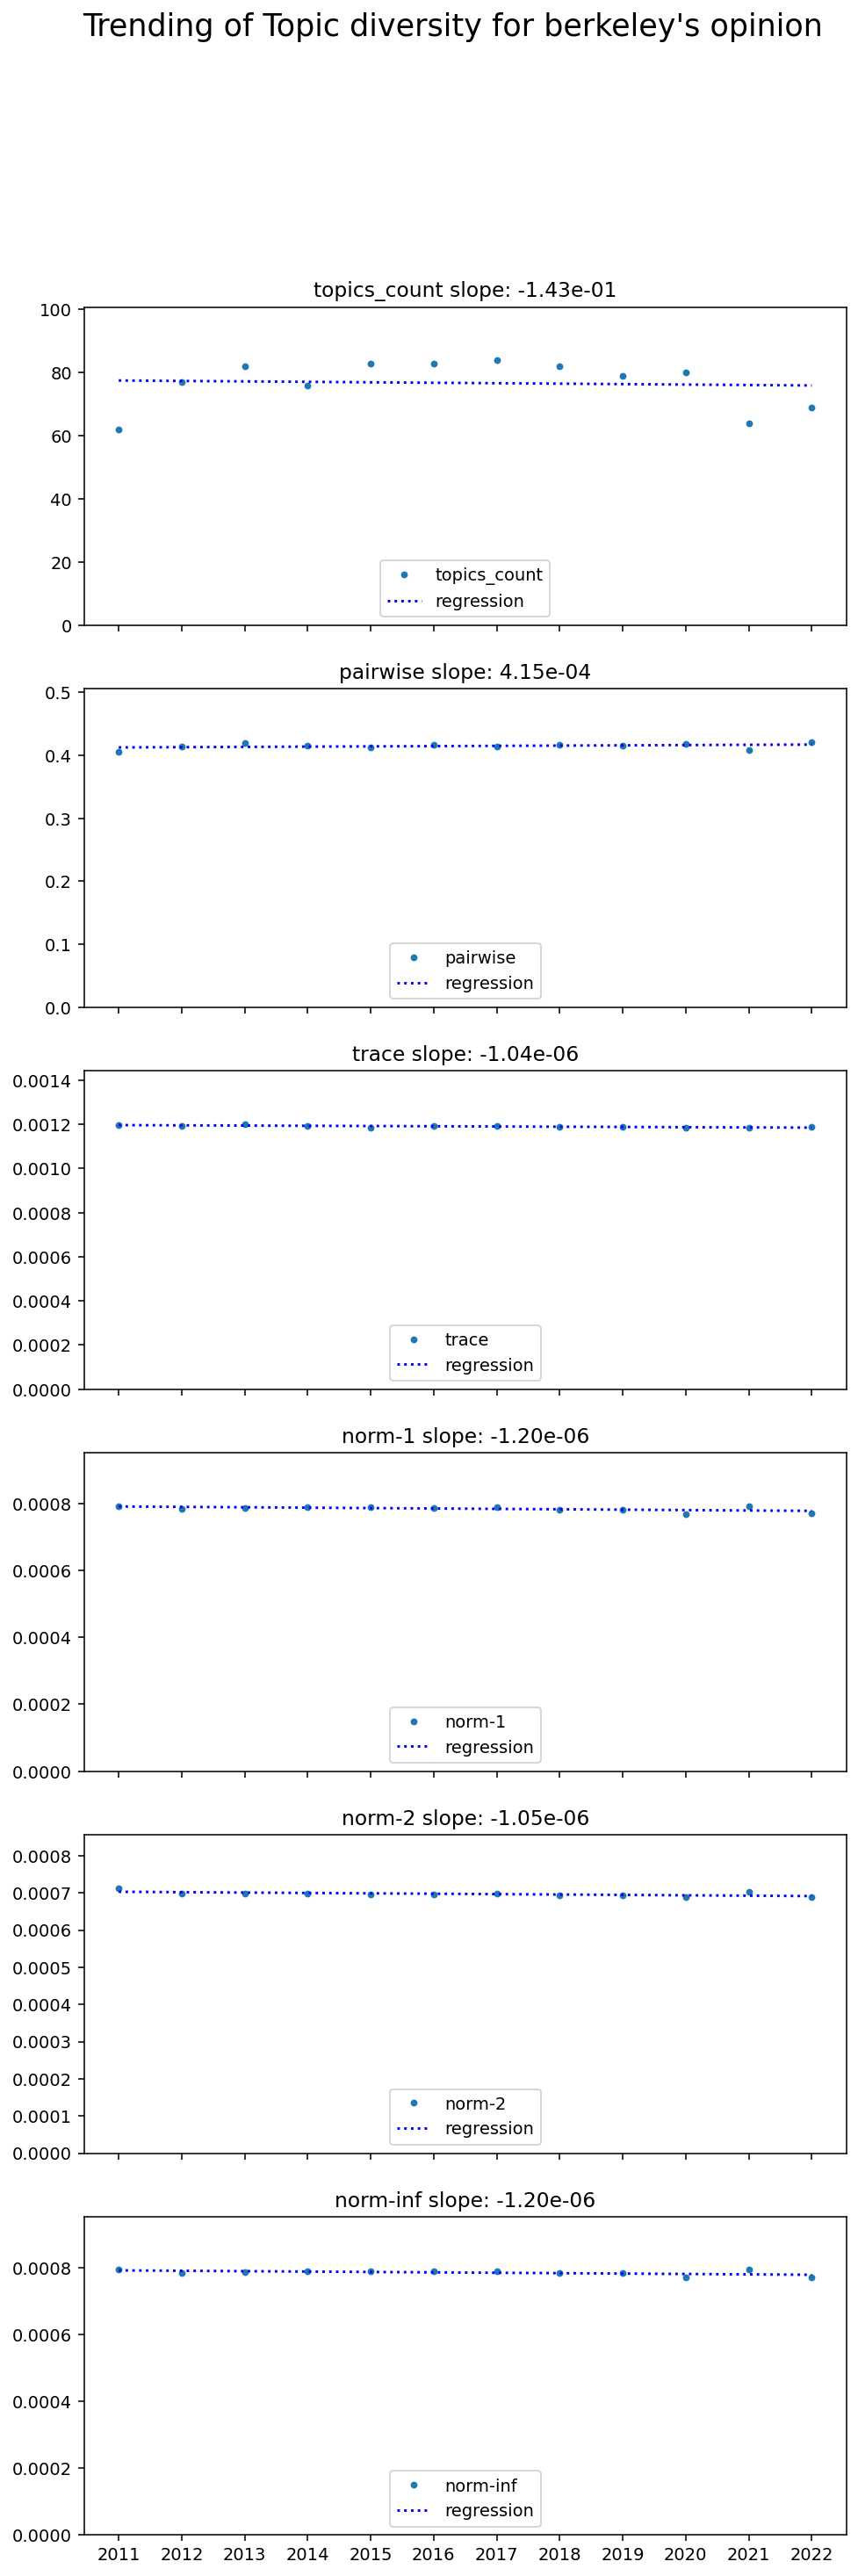

In [69]:
title = "Trending of Topic diversity for {}'s {}".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise", 'trace', 'norm-1', 'norm-2', 'norm-inf']
graph = ourgraphs.showTopicsResults(topics_trend_df, title, columns)
graph.show()

topics_count slope:-0.14336, int:77.53846, r:-0.06764, p:0.83454, se:0.66863, x:range(0, 12)
pairwise slope:0.00041, int:0.41261, r:0.33257, p:0.29087, se:0.00037, x:range(0, 12)


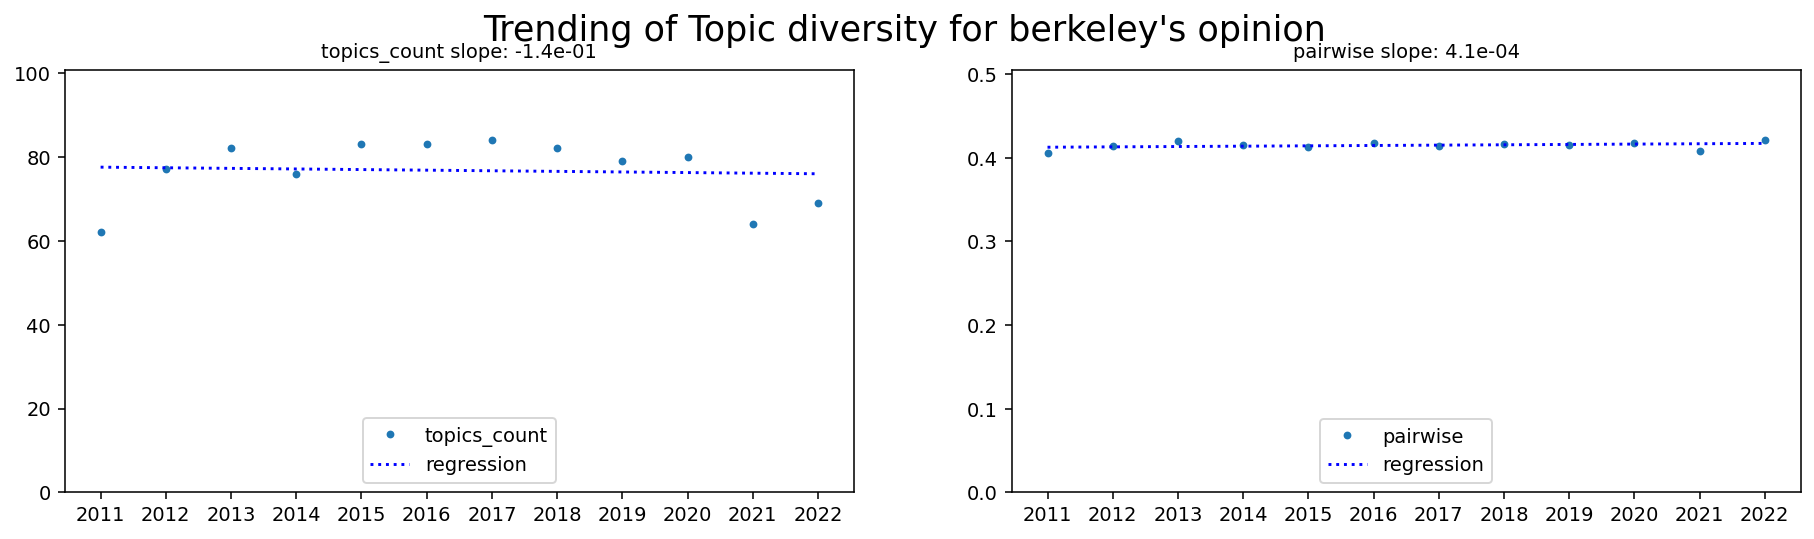

In [71]:
title = "Trending of Topic diversity for {}'s {}\n".format(
    SCHOOL, SUBJECT
)
columns = ["topics_count", "pairwise"]
graph = ourgraphs.showKeyTopicsResults(topics_trend_df, title, columns)
graph.show()

In [72]:
all_topics = topic_model.get_topics()
len(all_topics)

103

### Optionally: remove topic '2' which seems to be an outlier

In [ ]:
del all_topics[3]

In [ ]:
topic_model.visualize_topics_over_time(topics_over_time, topics=all_topics.keys())